In [24]:
import pandas as pd
import numpy as np
import itertools


N = 500
T = 500

u_i = np.random.uniform(0, 1, size=N)
x_i0 = np.random.binomial(1, p=u_i)

u = [u_i]
x = [x_i0]
y = [[None]*N]

for t in np.arange(1, T):
    u.append(u_i)
    x.append(np.random.binomial(1, p=1/(1 + np.exp(-2.*u_i))))
    y.append(np.random.normal(6.*u_i + 3.*x[t] + x[t-1]))
    
x = np.array(x)
u = np.array(u)
y = np.array(y)

df = pd.DataFrame([{"i": i, "t": t} for i, t in itertools.product(range(N), range(T))])
df['$X_{it}$'] = df[['i', 't']].apply(lambda row: x[row['t']][row['i']], axis=1)
df['$Y_{it}$'] = df[['i', 't']].apply(lambda row: y[row['t']][row['i']], axis=1)

df = df.dropna()

In [25]:
df.corr()

,i,t,$X_{it}$,$Y_{it}$
i,1.000000e+00,-1.256870e-15,-0.007603,-0.022747
t,-1.256870e-15,1.000000e+00,-0.000024,0.001267
$X_{it}$,-7.602593e-03,-2.396131e-05,1.000000,0.651225
$Y_{it}$,-2.274714e-02,1.267174e-03,0.651225,1.000000


In [26]:
df = df.groupby('i').apply(lambda x: x.sort_values('t')).reset_index(drop=True)
df['$X_{i t-1}$'] = df.groupby('i').apply(lambda x: x.sort_values('t').shift(1)).reset_index(drop=True)['$X_{it}$']

# Infer the confounder

In [4]:
X = df.pivot(columns='i', index='t', values='$X_{it}$')
X

i,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
t,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,1,1,1,1,...,1,0,0,1,0,1,0,1,1,1
2,0,1,1,0,1,0,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
3,1,1,1,1,0,1,1,1,0,0,...,1,1,1,1,0,1,1,1,0,1
4,0,1,1,1,1,1,1,1,0,0,...,1,1,1,1,0,1,1,0,1,1
5,0,0,1,1,0,1,0,1,0,0,...,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,1,0,1,1
496,1,0,1,0,1,0,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
497,1,0,1,1,1,1,0,1,0,1,...,1,1,1,1,0,1,0,1,1,1


In [17]:
from sklearn.decomposition import NMF


model = NMF(n_components=1)
model = model.fit(X)
u_inferred = model.components_[0]
df['U_inferred'] = df['i'].apply(lambda i: u_inferred[i])
df['U_true'] = df['i'].apply(lambda i: u_i[i])

/home/akelleh/.virtualenvs/data/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/akelleh/.virtualenvs/data/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


<AxesSubplot:xlabel='U_inferred', ylabel='U_true'>

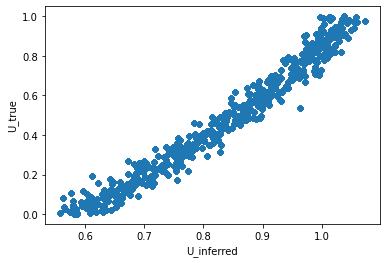

In [18]:
df.plot(x='U_inferred', y='U_true', kind='scatter')

In [19]:
df.corr()

,i,t,$X_{it}$,$Y_{it}$,$X_{i t-1}$,U_inferred,U_true,intercept
i,1.000000e+00,-1.256870e-15,0.005311,0.016092,0.005321,2.084742e-02,2.038545e-02,NaN
t,-1.256870e-15,1.000000e+00,0.000853,0.001667,0.000960,-3.078547e-16,-3.772586e-16,NaN
$X_{it}$,5.310709e-03,8.531146e-04,1.000000,0.656150,0.063729,2.583626e-01,2.533360e-01,NaN
$Y_{it}$,1.609181e-02,1.667114e-03,0.656150,1.000000,0.351951,7.814974e-01,7.906747e-01,NaN
$X_{i t-1}$,5.320723e-03,9.599014e-04,0.063729,0.351951,1.000000,2.583877e-01,2.533262e-01,NaN
U_inferred,2.084742e-02,-3.078547e-16,0.258363,0.781497,0.258388,1.000000e+00,9.805010e-01,NaN
U_true,2.038545e-02,-3.772586e-16,0.253336,0.790675,0.253326,9.805010e-01,1.000000e+00,NaN
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.groupby('i').mean().corr()

,t,$X_{it}$,$Y_{it}$,$X_{i t-1}$,U_inferred,U_true,intercept
t,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$X_{it}$,NaN,1.000000,0.987422,0.999971,0.999989,0.980534,NaN
$Y_{it}$,NaN,0.987422,1.000000,0.987288,0.987389,0.998984,NaN
$X_{i t-1}$,NaN,0.999971,0.987288,1.000000,0.999960,0.980373,NaN
U_inferred,NaN,0.999989,0.987389,0.999960,1.000000,0.980501,NaN
U_true,NaN,0.980534,0.998984,0.980373,0.980501,1.000000,NaN
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
from statsmodels.api import OLS


df['intercept'] = 1.

model = OLS(endog=df['$Y_{it}$'], exog=df[['$X_{it}$', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               $Y_{it}$   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                 1.886e+05
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:57:59   Log-Likelihood:            -5.4012e+05
No. Observations:              249500   AIC:                         1.080e+06
Df Residuals:                  249498   BIC:                         1.080e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
$X_{it}$       4.0541      0.009    434.312      0.000       4.036       4.072
intercept      2.9215      0.008    370.547      0.000       2.906       2.937
==============================================================================
Omnibus:                     7649.424   Durbin-Watson:                   0.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3671.329
Skew:                          -0.048   Prob(JB):                         0.00
Kurtosis:                       2.413   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
df['intercept'] = 1.

model = OLS(endog=df['$Y_{it}$'], exog=df[['$X_{it}$', 'U_inferred', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               $Y_{it}$   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 6.171e+05
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:58:00   Log-Likelihood:            -3.8796e+05
No. Observations:              249500   AIC:                         7.759e+05
Df Residuals:                  249497   BIC:                         7.760e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
$X_{it}$       3.0073      0.005    572.725      0.000       2.997       3.018
U_inferred    13.3531      0.017    771.600      0.000      13.319      13.387
intercept     -7.5325      0.014   -530.093      0.000      -7.560      -7.505
==============================================================================
Omnibus:                      118.329   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.495
Skew:                          -0.053   Prob(JB):                     1.86e-26
Kurtosis:                       2.996   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""